# 2021 BISSIT TEAM PROJECT

# TEXT SENTIMENT CLASSIFICATION 

**Team no.3**

Jeong Young-Yun, Cho Yun Keun, Park Woo Seok

In [ ]:
!pip install pytreebank
!pip install nltk

  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37071 sha256=18de31d4ebd67ddac4bbc901c1b7d788fa3528b77ef342d6ace49fd76b322e80
  Stored in directory: /root/.cache/pip/wheels/5b/84/1b/8fbd390149c4c56517bf3cb62bb25d3cf6f5cf575e66710ced
Successfully built pytreebank


In [ ]:
import pytreebank
import sys
import os

# Data frame
import pandas as pd

# Text pre-processing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Model training 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# The confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Data load

out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w', encoding='UTF-8') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

# Read data
def data_read(file) :
    df = pd.read_csv(f'./sst_{file}.txt', sep='\t', header=None, names=['truth', 'text'])
    df['truth'] = df['truth'].str.replace('__label__', '')
    df['truth'] = df['truth'].astype(int).astype('category')
    return df

In [ ]:
# Text pre-processing

def text_cleaning(data):
    # non-alphabetic character is converted to a space 
    only_english = re.sub('[^a-zA-Z]', ' ', data)
 
    # capital letter is converted to a lowercase character    
    no_capitals = only_english.lower().split()
 
    # use stopwords modules to remove the terminology - the, a, ...
    stops = set(stopwords.words('english'))
    no_stops = [word for word in no_capitals if not word in stops]
 
    # use the nltk module to perform stemming
    stemmer = nltk.stem.SnowballStemmer('english')
    stemmer_words = [stemmer.stem(word) for word in no_stops] 
 
    # return result list
    return stemmer_words

def data_preprocessing(df) : 
    # count word & Vectorization
    vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x)) 
    bow_vect = vect.fit_transform(df['text'].tolist()) 

    # TF-IDF (Term-frequency Inverse document frequency)
    # to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative 
    tfidf_vectorizer = TfidfTransformer()
    tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)
    
    return tf_idf_vect, df['truth']

In [ ]:
# Result : Matrix & Accuracy & F1 score
# For the code that visualizes the matrix, see the tutorial.
def plot_confusion_matrix(y_true, y_pred, 
                          classes=[1, 2, 3, 4, 5],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

def print_result(y_test, y_pred) :
    print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('F1: %.2f' % f1_score(y_test, y_pred, average='macro'))
    plot_confusion_matrix(y_test, y_pred)

In [ ]:
# Training setup

df_train = data_read('train') 
df_test = data_read('test') 

df_total = pd.concat([df_train, df_test])

x, y = data_preprocessing(df_total) # x = TF-IDF, y = Score[1-5]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)

# Training the model

model = LogisticRegression(solver='liblinear', multi_class='auto')
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy: 0.40
F1: 0.33


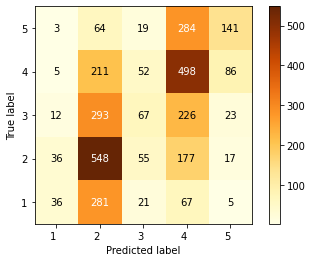

In [ ]:
# Classification prediction
y_pred = model.predict(x_test)

# Result
print_result(y_test, y_pred)

In [ ]:
df_train['truth'].value_counts()

# Different data rates, not balanced in accuracy.

4    2322
2    2218
3    1624
5    1288
1    1092
Name: truth, dtype: int64

In [ ]:
# Distribute the data in categories equally by 1000

df = df_train
one_idx = df[df['truth']==1].sample(1000, random_state=12).index.tolist()
two_idx = df[df['truth']==2].sample(1000, random_state=12).index.tolist()
three_idx = df[df['truth']==3].sample(1000, random_state=12).index.tolist()
four_idx = df[df['truth']==4].sample(1000, random_state=12).index.tolist()
five_idx = df[df['truth']==5].sample(1000, random_state=12).index.tolist()

random_idx = one_idx + two_idx + three_idx + four_idx + five_idx
x = x[random_idx]
y = df['truth'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

accuracy: 0.37
F1: 0.37


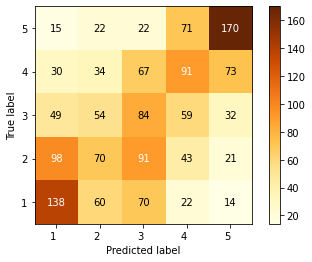

In [ ]:
# Model re-training

model2 = LogisticRegression(solver='liblinear', multi_class='auto')
model2.fit(x_train, y_train)

y_pred2 = model2.predict(x_test)
print_result(y_test, y_pred2)